In [3]:
!pip install timm
!pip install einops
!pip install spectral

# Diffusion Model Architecture & Training

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from timm.utils import ModelEmaV3
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import h5py

#positional embeddings
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings  # shape: (time_steps, embed_dim)

    def forward(self, t):
        t = t.long().to(self.embeddings.device)
        embeds = self.embeddings[t].to(t.device)  # shape: (batch_size, embed_dim)
        embeds = embeds[:, :, None]  # add channel dimension for FiLM
        return embeds  # shape: (batch_size, embed_dim, 1)

In [5]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float, embed_dim: int = 512):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv1d(C, C, kernel_size=9, padding=4, dilation=1)
        self.conv2 = nn.Conv1d(C, C, kernel_size=9, padding=4, dilation=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

        # Embedding MLP → produce gamma and beta
        self.emb_proj = nn.Sequential(
            nn.Linear(embed_dim, 2 * C),
            nn.SiLU(),
            nn.Linear(2 * C, 2 * C)
        )

    def forward(self, x, embeddings):
        # Compute gamma, beta from embeddings
        gamma_beta = self.emb_proj(embeddings.squeeze(-1))
        gamma, beta = torch.chunk(gamma_beta, 2, dim=1)
        gamma = gamma.unsqueeze(-1)
        beta = beta.unsqueeze(-1)

        # Apply FiLM conditioning (scale + shift)
        h = self.conv1(self.relu(self.gnorm1(x)))
        h = h * (1 + gamma) + beta  # << this is the key line
        h = self.dropout(h)
        h = self.conv2(self.relu(self.gnorm2(h)))
        return h + x

In [6]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        length = x.shape[2]
        x = rearrange(x, 'b c l -> b l c')
        x = self.proj1(x)
        x = rearrange(x, 'b l (C H K) -> K b H l C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H l C -> b l (C H)')
        x = self.proj2(x)
        return rearrange(x, 'b l C -> b C l')

In [7]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            last_layer: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale and not last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=5, stride=2, padding=2, output_padding=1)
        elif last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=5, stride=2, padding=2)
        else:
            self.conv = nn.Conv1d(C, C*2, kernel_size=5, stride=2, padding=2)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        #print(x.shape, self.conv(x).shape)
        return self.conv(x), x

In [8]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            last_layers: List = [False, False, False, False, False, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1500):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv1d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv1d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv1d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                last_layer=last_layers[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(t).to(x.device)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            residual = residuals[self.num_layers - i - 1]
            x = torch.concat((layer(x, embeddings)[0], residual), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [9]:
model = UNET()

# Generate a random 1D input tensor of shape (batch_size, input_channels, length)
batch_size = 1  # You can change this to whatever batch size you need
input_length = 519  # As specified
input_tensor = torch.randn(batch_size, 1, input_length)  # Shape: (1, 1, 519)

# Generate a random time step tensor
time_steps = torch.randint(0, 1500, (batch_size,))  # Randomly generating time steps

# Pass the input tensor through the model
output = model(input_tensor, time_steps)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 519])


In [10]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1500):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False).cuda()
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False).cuda()

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [11]:
import h5py

with h5py.File('/home/nnara/notebooks/icvl_50k_spectra_eve.h5', 'r') as f:
    # List available datasets inside the file
    print(list(f.keys()))
    icvl_data = f['spectra'][:]

print(icvl_data.shape)

['spectra']
(50000, 519)


In [12]:
class SpectralDataset(Dataset):
  def __init__(self, data):
    self.data = torch.from_numpy(data)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [13]:
import os
#batch size must be compatible with number of data points (1,000,000)
def train(batch_size: int=250,
          num_time_steps: int=1000,
          num_epochs: int=1,
          seed: int=-1,
          ema_decay: float=0.9999,
          lr=2e-5,
          checkpoint_path: str=None):
    #set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = SpectralDataset(data)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, x in enumerate(tqdm(train_dataloader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1).cuda()
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (999990/batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    torch.save(checkpoint, '/home/nnara/notebooks/ddpm_checkpoint_old.pth')

In [ ]:
train(checkpoint_path='/home/nnara/notebooks/ddpm_checkpoint_old.pth', lr=2e-5, num_epochs=10)

# Spectra Generation

In [14]:
wavelengths = np.load("/home/nnara/notebooks/icvl_wavelengths_519.npy")

In [17]:
import h5py

with h5py.File('/home/nnara/notebooks/icvl_500k_spectra_4cam.h5', 'r') as f:
    # List available datasets inside the file
    print(list(f.keys()))
    cam_data = f['spectra'][:]

print(cam_data.shape)

['spectra']
(500000, 519)


In [18]:
import h5py

with h5py.File('/home/nnara/notebooks/icvl_500k_spectra_objects.h5', 'r') as f:
    # List available datasets inside the file
    print(list(f.keys()))
    objects_data = f['spectra'][:]

print(objects_data.shape)

['spectra']
(500000, 519)


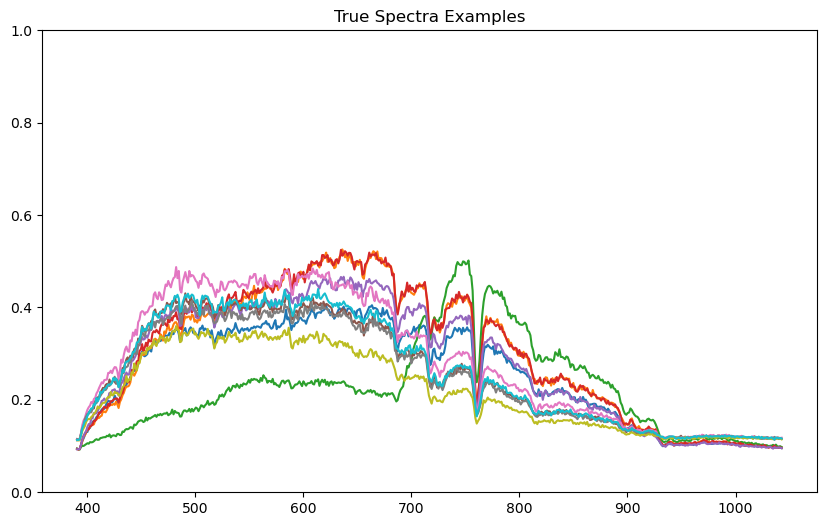

In [25]:
plt.figure(figsize=(10, 6))

for i in range(5):
  index = random.randint(0, cam_data.shape[0])
  plt.plot(wavelengths, cam_data[index, :])

for i in range(5):
  index = random.randint(0, objects_data.shape[0])
  plt.plot(wavelengths, objects_data[index, :])

plt.title("True Spectra Examples")
plt.ylim(0,1);

In [20]:
class DDIM_Scheduler(nn.Module):
    def __init__(self, num_time_steps=1500):
        super().__init__()
        self.num_time_steps = num_time_steps
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps).cuda()
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).cuda()

    def ddim_update(self, model_output, x, t, t_next):
        alpha_t = self.alpha_cumprod[t].view(-1, 1, 1).cuda()
        alpha_t_next = self.alpha_cumprod[t_next].view(-1, 1, 1).cuda() if t_next >= 0 else torch.ones_like(alpha_t)

        # Predict x_0 (denoised image)
        pred_x0 = (x - torch.sqrt(1 - alpha_t) * model_output) / torch.sqrt(alpha_t)

        # Calculate the DDIM update step
        direction = torch.sqrt(1 - alpha_t_next) * model_output
        x_next = torch.sqrt(alpha_t_next) * pred_x0 + direction

        return x_next

In [21]:
def ddim_inference(checkpoint_path: str=None,
                   num_time_steps: int=1500,
                   num_inference_steps: int=50,
                   ema_decay: float=0.9999,
                   batch_size: int = 1):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDIM_Scheduler(num_time_steps=num_time_steps)
    spectra = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(100):  # Generate 100 spectra
            z = torch.randn(batch_size, 1, 519).cuda()  # Initial noise
            timesteps = torch.linspace(0, num_time_steps - 1, num_inference_steps).long().flip(0)

            for idx in range(num_inference_steps - 1):
                t = timesteps[idx].expand(batch_size).to(z.device)
                t_next = timesteps[idx + 1].expand(batch_size).to(z.device)
                model_output = model(z, t)
                z = scheduler.ddim_update(model_output, z, t, t_next)

            t_last = timesteps[-1].expand(batch_size).to(z.device)
            t_next_last = -torch.ones_like(t_last)
            model_output = model(z, t_last)
            z = scheduler.ddim_update(model_output, z, t_last, t_next_last)

            spectra.append(z.squeeze(0).cpu().numpy())

    return spectra

In [26]:
spectra = ddim_inference('/home/nnara/notebooks/ddpm_checkpoint_519band_old.pth')

/tmp/ipykernel_4085011/677174758.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


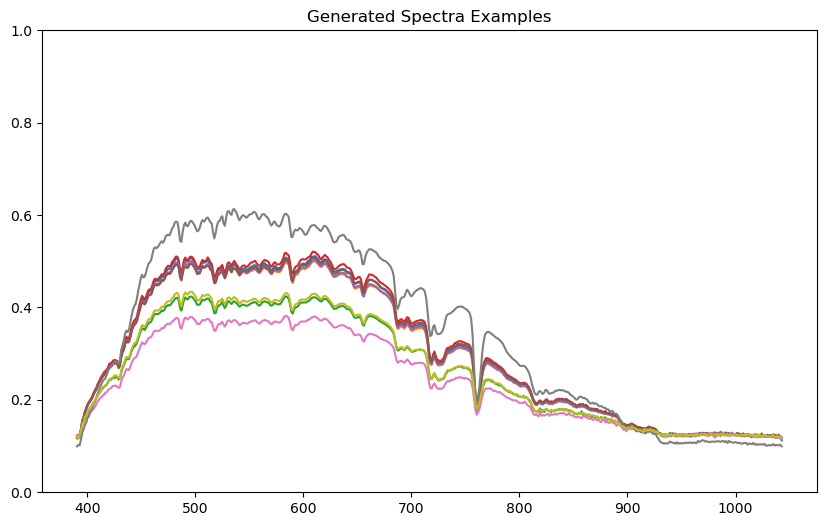

In [31]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

for i, spectrum in enumerate(spectra):
    spectrum = spectrum.squeeze()

    if i > 40 and i < 50:
      plt.plot(wavelengths, spectrum)


plt.title('Generated Spectra Examples')
plt.ylim(0,1);

# Denoising

In [28]:
#base class for different tasks like super resolution, denoising, inpainting, etc.
# Base class/interface
class H_functions:
    def H(self, x):
        raise NotImplementedError()
    def Ht(self, y):
        raise NotImplementedError()
    def H_pinv(self, y):
        return self.Ht(y)  # default pseudo-inverse
    def V(self, vec):
        return vec
    def Vt(self, vec):
        return vec
    def U(self, vec):
        return vec
    def Ut(self, vec):
        return vec
    def singulars(self):
        raise NotImplementedError()
    def add_zeros(self, vec):
        return vec

In [29]:
class Denoising(H_functions):
    def __init__(self, target_db, num_wavelengths=519):
        self.target_db = target_db
        self.num_wavelengths = num_wavelengths
        self._singulars = torch.ones(num_wavelengths).cuda()

    def H(self, x):
        signal_power = torch.mean(x ** 2)
        noise_power = signal_power / (10 ** (self.target_db / 10))
        noise = torch.randn_like(x) * torch.sqrt(noise_power)
        return x + noise

    def Ht(self, y):
        return y  # identity for denoising

    def singulars(self):
        return self._singulars


In [32]:
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).cuda(), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1)
    return a

def ddrm_inference(
    checkpoint_path,
    x,      # Input data point (1xL vector)
    seq,    # Sequence of timesteps for sampling
    H_funcs,
    sigma_0=0.1,
    etaB=0.85,
    etaA=0.5,
    etaC=0.5
):
    # Load model checkpoint
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=0.9999)
    ema.load_state_dict(checkpoint['ema'])
    model.eval()

    # Convert input to tensor
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
    x = x.cuda()

    # Apply forward H (corruption)
    x = H_funcs.H(x)

    # Beta schedule
    b = torch.linspace(1e-4, 0.02, 1500).to(x.device)

    with torch.no_grad():
        # DDRM setup
        singulars = H_funcs.singulars()
        Sigma = torch.zeros(x.shape[2], device=x.device)
        Sigma[:singulars.shape[0]] = singulars

        y_0 = x.clone()
        U_t_y = H_funcs.Ut(y_0)
        Sig_inv_U_t_y = U_t_y / singulars[:U_t_y.shape[-1]]

        largest_alphas = compute_alpha(b, (torch.ones(x.size(0)) * seq[-1]).to(x.device).long())
        largest_sigmas = (1 - largest_alphas).sqrt() / largest_alphas.sqrt()

        # Identify significant singulars
        large_singulars_index = torch.where(singulars * largest_sigmas[0,0,0] > sigma_0)
        inv_singulars_and_zero = torch.zeros(x.shape[2], device=x.device)
        inv_singulars_and_zero[large_singulars_index] = sigma_0 / singulars[large_singulars_index]
        inv_singulars_and_zero = inv_singulars_and_zero.view(1, -1)

        # Initial estimate
        init_y = torch.zeros(x.shape[0], x.shape[2], device=x.device)
        init_y[:, large_singulars_index[0]] = U_t_y[:, :, large_singulars_index[0]] / singulars[large_singulars_index].view(1, -1)
        init_y = init_y.view(*x.shape)

        remaining_s = largest_sigmas.view(-1,1)**2 - inv_singulars_and_zero**2
        remaining_s = remaining_s.view(x.shape[0], x.shape[2]).clamp_min(0.0).sqrt()
        init_y = (init_y + remaining_s * x) / largest_sigmas

        x = H_funcs.V(init_y)

        n = x.size(0)
        seq_next = [-1] + list(seq[:-1])
        x0_preds = []
        xs = [x]

        for i, j in tqdm(zip(reversed(seq), reversed(seq_next))):
            t = (torch.ones(n) * i).to(x.device)
            next_t = (torch.ones(n) * j).to(x.device)

            at = compute_alpha(b, t.long())
            at_next = compute_alpha(b, next_t.long())

            xt = xs[-1].to('cuda')
            et = model(xt, t)
            x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()

            sigma_next = (1 - at_next).sqrt()[0,0,0] / at_next.sqrt()[0,0,0]
            
            #DDRM measurement-space update
            V_t_x0 = H_funcs.Vt(x0_t)
            SVt_x0 = (V_t_x0 * Sigma)[:, :U_t_y.shape[2]]

            # Conditional logic for different noise scenarios
            falses = torch.zeros(V_t_x0.shape[2] - singulars.shape[0], dtype=torch.bool, device=xt.device)
            cond_before_lite = singulars * sigma_next > sigma_0
            cond_after_lite = singulars * sigma_next < sigma_0
            cond_before = torch.hstack((cond_before_lite, falses))
            cond_after = torch.hstack((cond_after_lite, falses))

            std_nextC = sigma_next * etaC
            sigma_tilde_nextC = torch.sqrt(sigma_next**2 - std_nextC**2)
            std_nextA = sigma_next * etaA
            sigma_tilde_nextA = torch.sqrt(sigma_next**2 - std_nextA**2)
            diff_sigma_t_nextB = torch.sqrt(sigma_next**2 - sigma_0**2 / singulars[cond_before_lite]**2 * etaB**2)

            # Base updates
            #Optional random noise addition that would replace line below: Vt_xt_mod_next = V_t_x0 + sigma_tilde_nextC * H_funcs.Vt(et) + std_nextC * torch.randn_like(V_t_x0)
            Vt_xt_mod_next = V_t_x0.clone()
            # Less noisy components
            Vt_xt_mod_next[:, :, cond_after] = V_t_x0[:, :, cond_after] + sigma_tilde_nextA * ((U_t_y - SVt_x0)/sigma_0)[:, :, cond_after_lite] + std_nextA * torch.randn_like(V_t_x0[:, :, cond_after])

            # More noisy components
            Vt_xt_mod_next[:, :, cond_before] = (Sig_inv_U_t_y[:, :, cond_before_lite] * etaB + 
                                                 (1 - etaB) * V_t_x0[:, :, cond_before] + 
                                                 diff_sigma_t_nextB * torch.randn_like(U_t_y)[:, :, cond_before_lite])
            
            # Map back to high-dim while preserving model-predicted high-freq info
            xt_next = H_funcs.V(Vt_xt_mod_next) + (x0_t - H_funcs.V(H_funcs.Vt(x0_t)))
            xt_next = (at_next.sqrt()[0,0,0] * xt_next).view(*x.shape)

            x0_preds.append(x0_t.to('cpu'))
            xs.append(xt_next.to('cpu'))

    return xs, x0_preds, y_0

In [27]:
#ddrm_inference('/home/nnara/checkpoints/ddpm_checkpoint.pth')
seq = list(range(0, 1500, 50))
H_funcs = Denoising(target_db=10)
true_waves = []
noised_waves = []
preds = []

for i in range(3):
  rand = random.randint(0 ,50000)
  x = icvl_data[rand].reshape(1, -1, 519)
  predictions = ddrm_inference('/home/nnara/notebooks/ddpm_checkpoint_519band_old.pth', x, seq, H_funcs, 0.05, 0.9, 0.3, 0.5)
  true_waves.append(x)
  preds.append(predictions[0])
  noised_waves.append(predictions[2])

/tmp/ipykernel_3159847/3971427154.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
30it [00:02, 11.21it/s]
30it [00:02, 11.23it/

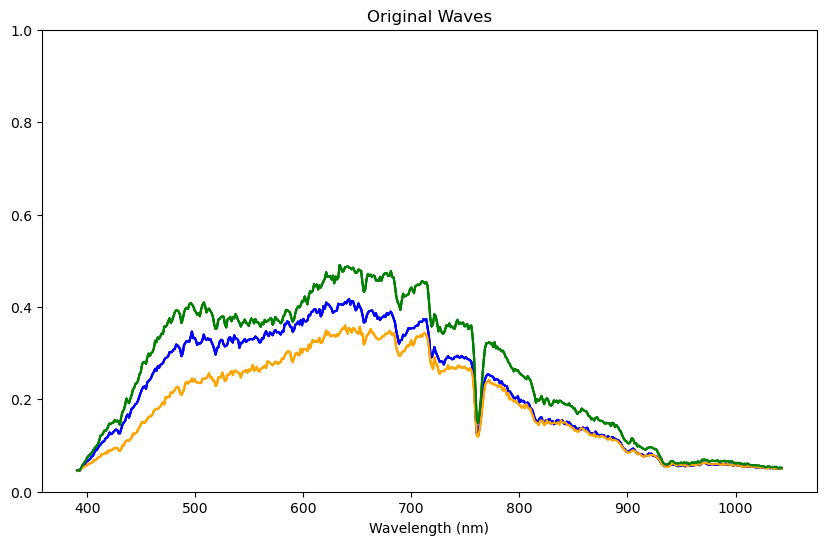

In [29]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']

for x in true_waves:
  for i, wave in enumerate(true_waves):
      wave = wave.squeeze()
      plt.plot(list(wavelengths), wave, color=colors[i % len(colors)])

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Original Waves");

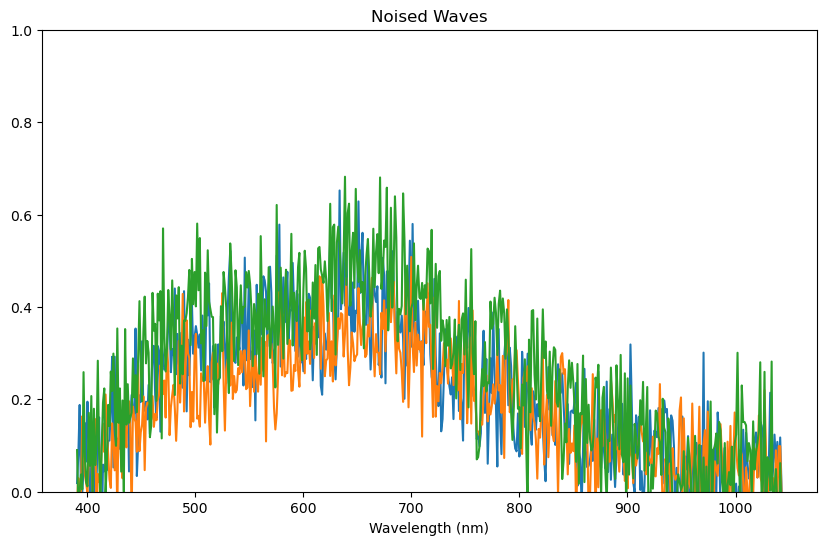

In [30]:
plt.figure(figsize=(10, 6))

for wave in noised_waves:
  for i, p in enumerate(wave):
      p = p.squeeze()
      #plt.plot(range(420,721,10), p.cpu())
      plt.plot(wavelengths, p.cpu())

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Noised Waves");

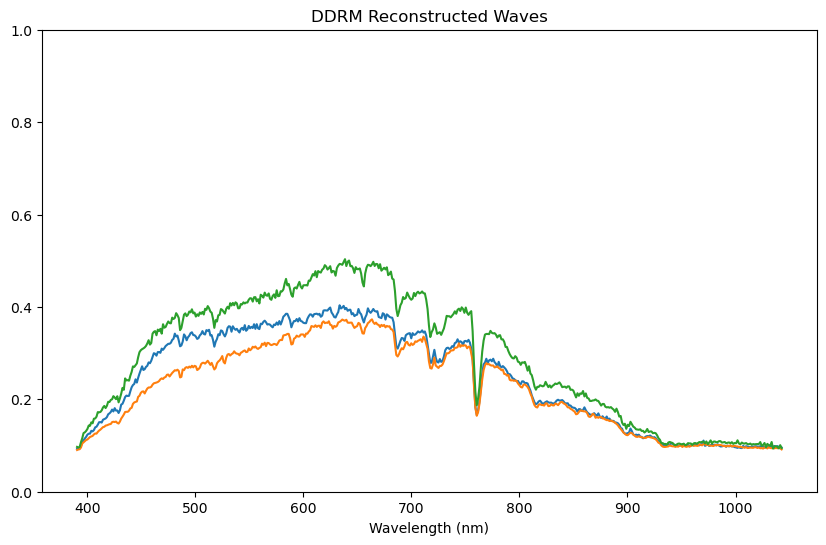

In [31]:
plt.figure(figsize=(10, 6))

for pred in preds:
  for i, p in enumerate(pred[-1]):
      p = p.squeeze()
      plt.plot(wavelengths, p.cpu())

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("DDRM Reconstructed Waves");

# Comparing Performance to Existing Denoisers

In [39]:
!pip install PyWavelets
import pywt

In [40]:
def bayes_threshold(coeffs):
    sigma_sq = np.var(coeffs)
    return sigma_sq / np.sqrt(max(sigma_sq - np.var(coeffs), 1e-6))

def wavelet_denoise(signal, wavelet='db4', level=2, threshold_method='soft'):
    """

    Parameters:
    - signal: 1D NumPy array (1x519)
    - wavelet: Wavelet type (default='db4')
    - level: Decomposition level (default=2)
    - threshold_method: 'soft' or 'hard' thresholding

    Returns:
    - denoised_signal: Reconstructed denoised signal (1x519)
    """

    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    thresholds = [bayes_threshold(c) for c in coeffs[1:]]

    # Apply adaptive thresholding to detail coefficients
    new_coeffs = [coeffs[0]]  # Keep approximation coefficients
    for i, c in enumerate(coeffs[1:]):
        new_coeffs.append(pywt.threshold(c, thresholds[i], mode=threshold_method))
    denoised_signal = pywt.waverec(new_coeffs, wavelet)

    # Trim to original length (waverec may return a slightly longer array)
    return denoised_signal[:, :signal.shape[-1]]

In [24]:
wavelet_denoised = []
for wave in noised_waves:
  denoised = wavelet_denoise(wave.reshape(1,519).cpu())
  wavelet_denoised.append(denoised)

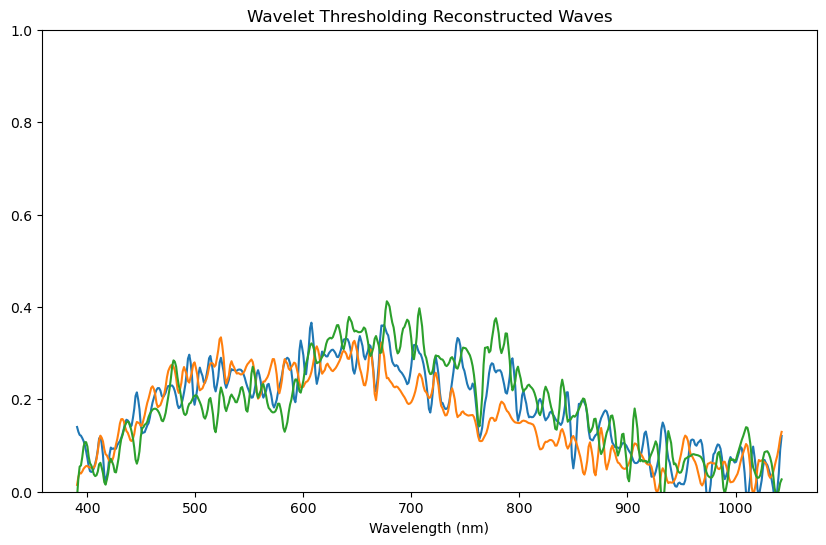

In [25]:
plt.figure(figsize=(10, 6))

for wave in wavelet_denoised:
  for point in wave:
      plt.plot(wavelengths, point)

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Wavelet Thresholding Reconstructed Waves");

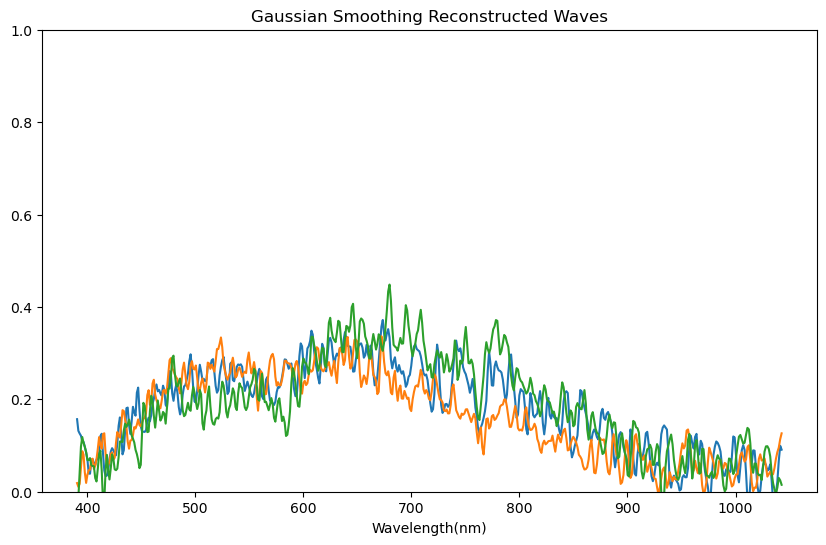

In [26]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(10, 6))

# Apply Gaussian smoothing with standard deviation (sigma)
sigma = 1
for wave in noised_waves:
  smoothed_wave = gaussian_filter1d(wave.cpu(), sigma).reshape(1,519)
  for point in smoothed_wave:
    plt.plot(wavelengths, point)
plt.title("Gaussian Smoothing Reconstructed Waves")
plt.xlabel("Wavelength(nm)")
plt.ylim(0,1);

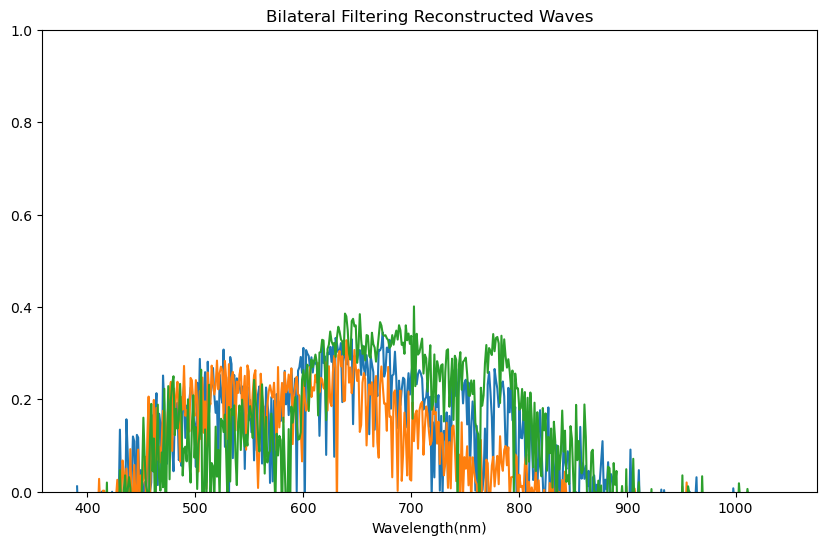

In [27]:
import numpy as np
from skimage.restoration import denoise_bilateral

plt.figure(figsize=(10, 6))

for wave in noised_waves:
  wave = np.array(wave.reshape(1,519).cpu())
  denoised = denoise_bilateral(wave, sigma_color=0.1, sigma_spatial=2).reshape(1,519)
  for point in denoised:
    plt.plot(wavelengths, point)
plt.title("Bilateral Filtering Reconstructed Waves")
plt.xlabel("Wavelength(nm)")
plt.ylim(0,1);

In [21]:
def mse(actual, pred):
  actual = np.array(actual) if not isinstance(actual, np.ndarray) else actual
  pred = np.array(pred) if not isinstance(pred, np.ndarray) else pred
  errors = np.abs((actual - pred)**2)
  return np.mean(errors)

def psnr(actual, pred, max_val=1.0):
   MSE = mse(actual, pred)
   if MSE == 0:
    return float('inf')  # perfect reconstruction
   psnr = 10 * np.log10((max_val ** 2) / MSE)
   return psnr

def sam(actual, pred, eps=1e-10, to_degrees=True):
    """
    Computes spectral angle between two spectra.
    Accepts shapes like (1, 1, 519), (1, 519), or (519,).
    Returns angle in degrees by default.
    """
    actual = np.array(actual).reshape(-1)  # becomes (519,)
    pred = np.array(pred).reshape(-1)      # becomes (519,)

    dot = np.dot(actual, pred)
    norm_actual = np.linalg.norm(actual)
    norm_pred = np.linalg.norm(pred)

    denom = max(norm_actual * norm_pred, eps)
    cos_theta = np.clip(dot / denom, -1.0, 1.0)

    theta = np.arccos(cos_theta)  # radians
    return theta * 180.0 / np.pi if to_degrees else theta


def DDRMreconstruction(dataset, num_waves, seq, H_funcs, sigma_0, etaB, etaA, etaC):
    accuracies = []
    wave_indices = random.sample(range(num_waves), 100)

    for target_db in [40, 30, 20, 10]:
        H_funcs = Denoising(target_db=target_db)
        true_waves = []
        preds = []

        for i in wave_indices:
            x = dataset[i].reshape(1, 1, 519)  # <-- your shape
            predictions = ddrm_inference(
                '/home/nnara/notebooks/ddpm_checkpoint_519band_old.pth',
                x, seq, H_funcs, sigma_0, etaB, etaA, etaC
            )
            true_waves.append(x)
            preds.append(predictions[0])  # a list of steps

        sam_scores = []
        for i in range(100):
            # Both are initially shape (1, 1, 519)
            actual = true_waves[i].reshape(-1)   # (519,)
            pred = preds[i][-1].reshape(-1)      # (519,)
            theta = sam(actual, pred)
            sam_scores.append(theta)

        avg_sam = np.mean(sam_scores)
        accuracies.append((target_db, avg_sam))

    return accuracies

In [33]:
seq = list(range(0, 1500, 50))
H_funcs = Denoising(target_db=10)
DDRM_accuracies = DDRMreconstruction(icvl_data, 50000, seq, H_funcs, 0.02, 0.85, 0.5, 0.5)

/tmp/ipykernel_3159847/3971427154.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
30it [00:02, 11.18it/s]
30it [00:02, 11.26it/

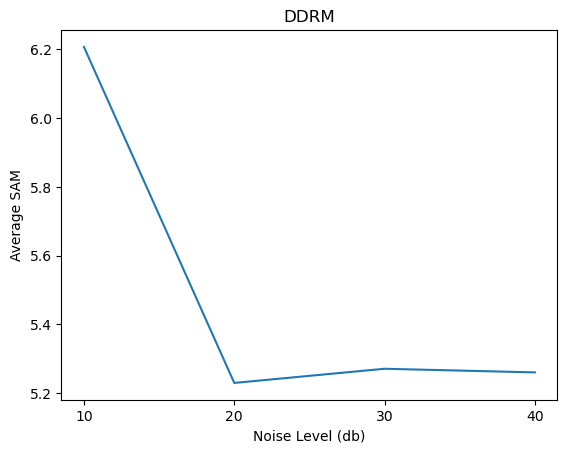

In [36]:
DDRM_x_vals = [i for (i,j) in DDRM_accuracies]
DDRM_y_vals = [j for (i, j) in DDRM_accuracies]
plt.plot(DDRM_x_vals, DDRM_y_vals)
plt.title("DDRM")
plt.ylabel("Average SAM")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);

In [50]:
def WaveletReconstruction(dataset, num_waves, wavelet='db4', level=2, threshold_method='soft'):
    accuracies = []
    wave_indices = [random.randint(0, num_waves) for i in range(100)]

    for target_db in [40, 30, 20, 10]:
        true_waves = []
        preds = []

        for i in wave_indices:
            x = dataset[i].reshape(1, 519)  # ensure shape (1, 519)

            # Add noise based on target SNR
            signal_power = np.mean(x ** 2)
            noise_power = signal_power / (10 ** (target_db / 10))
            noise = np.random.randn(*x.shape) * np.sqrt(noise_power)
            noisy_x = x + noise

            # Denoise using wavelet
            predictions = wavelet_denoise(noisy_x, wavelet, level, threshold_method)

            true_waves.append(x)             # clean/original
            preds.append(predictions)        # denoised

        sam_scores = []
        for i in range(100):
            actual = np.array(true_waves[i]).reshape(-1)  # -> (519,)
            pred = np.array(preds[i]).reshape(-1)         # -> (519,)
            theta = sam(actual, pred)
            sam_scores.append(theta)

        avg_sam = np.mean(sam_scores)
        accuracies.append((target_db, avg_sam))

    return accuracies

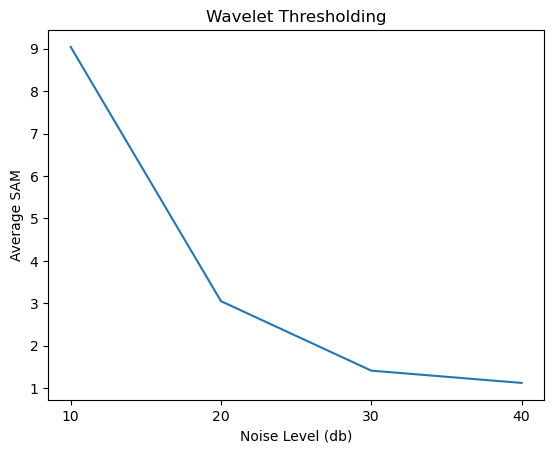

In [52]:
WR_accuracies = WaveletReconstruction(icvl_data, 50000)
WR_x_vals = [i for (i,j) in WR_accuracies]
WR_y_vals = [j for (i, j) in WR_accuracies]
plt.plot(WR_x_vals, WR_y_vals)
plt.title("Wavelet Thresholding")
plt.ylabel("Average SAM")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);

In [53]:
def GaussianReconstruction(dataset, num_waves, sigma=1):
    accuracies = []
    wave_indices = [random.randint(0, num_waves) for i in range(100)]

    for target_db in [40,30,20,10]:
        true_waves = []
        preds = []

        for i in wave_indices:
            x = dataset[i].reshape(1, 519)  # ensure consistent shape

            # Add noise according to target SNR
            signal_power = np.mean(x ** 2)
            noise_power = signal_power / (10 ** (target_db / 10))
            noise = np.random.randn(*x.shape) * np.sqrt(noise_power)
            noisy_x = x + noise

            # Apply Gaussian filtering
            predictions = gaussian_filter1d(noisy_x, sigma)

            true_waves.append(x)           # original clean wave
            preds.append(predictions)      # denoised wave

        sam_scores = []
        for i in range(100):
            actual = np.array(true_waves[i]).reshape(-1)  # -> (519,)
            pred = np.array(preds[i]).reshape(-1)         # -> (519,)
            theta = sam(actual, pred)
            sam_scores.append(theta)

        avg_sam = np.mean(sam_scores)
        accuracies.append((target_db, avg_sam))

    return accuracies

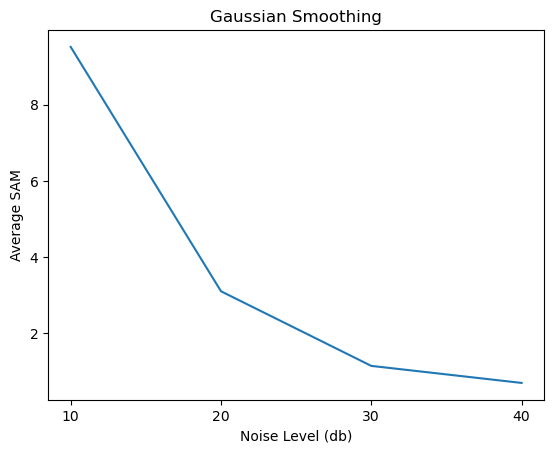

In [54]:
GS_accuracies = GaussianReconstruction(icvl_data, 50000)
GS_x_vals = [i for (i,j) in GS_accuracies]
GS_y_vals = [j for (i, j) in GS_accuracies]
plt.plot(GS_x_vals, GS_y_vals)
plt.title("Gaussian Smoothing")
plt.ylabel("Average SAM")
plt.xlabel("Noise Level (db)")
plt.xticks([40,30,20,10]);

In [55]:
def BilateralReconstruction(dataset, num_waves, sigma_color=0.1, sigma_spatial=2):
    accuracies = []
    wave_indices = [random.randint(0, num_waves) for i in range(100)]

    for target_db in [40,30,20,10]:
        true_waves = []
        preds = []

        for i in wave_indices:
            x = dataset[i].reshape(1, 519)  # ensure shape (1, 519)

            # Add noise according to target SNR
            signal_power = np.mean(x ** 2)
            noise_power = signal_power / (10 ** (target_db / 10))
            noise = np.random.randn(*x.shape) * np.sqrt(noise_power)
            noisy_x = x + noise

            # Apply bilateral denoising
            predictions = denoise_bilateral(
                noisy_x,
                sigma_color=sigma_color,
                sigma_spatial=sigma_spatial,
                bins=100
            ).reshape(1, 519)

            true_waves.append(x)           # original clean wave
            preds.append(predictions)      # denoised wave

        sam_scores = []
        for i in range(100):
            actual = np.array(true_waves[i]).reshape(-1)  # -> (519,)
            pred = np.array(preds[i]).reshape(-1)         # -> (519,)
            theta = sam(actual, pred)
            sam_scores.append(theta)

        avg_sam = np.mean(sam_scores)
        accuracies.append((target_db, avg_sam))

    return accuracies

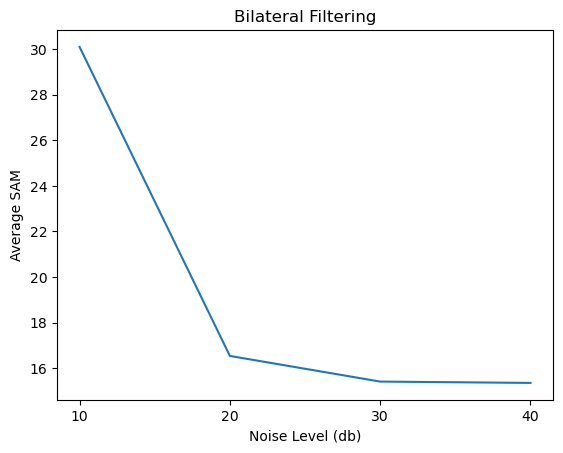

In [56]:
BR_accuracies = BilateralReconstruction(icvl_data, 50000)
BR_x_vals = [i for (i,j) in BR_accuracies]
BR_y_vals = [j for (i, j) in BR_accuracies]
plt.plot(BR_x_vals, BR_y_vals)
plt.title("Bilateral Filtering")
plt.ylabel("Average SAM")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);

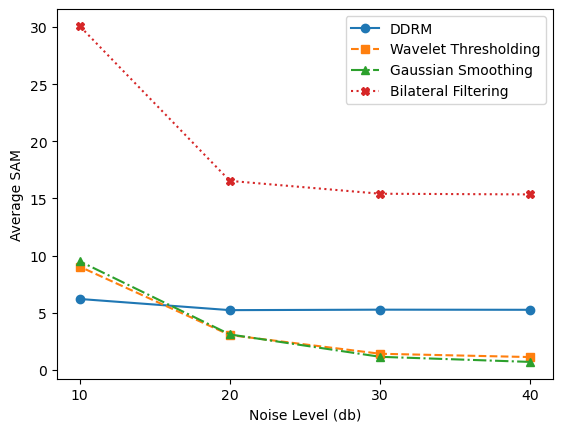

In [57]:
x = [DDRM_x_vals, WR_x_vals, GS_x_vals, BR_x_vals]
y = [DDRM_y_vals, WR_y_vals, GS_y_vals, BR_y_vals]
labels = ["DDRM", "Wavelet Thresholding", "Gaussian Smoothing", "Bilateral Filtering"]
markers = ['o','s','^','X']
linestyles = ['-','--','-.',':']
for i in range(len(x)):
  plt.plot(x[i], y[i], marker=markers[i], linestyle=linestyles[i],label=labels[i])

plt.legend()
plt.ylabel("Average SAM")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);

We can see above that DDRM achieves the best (lowest) SAM score at the highest noise level of 10db

# Super Resolution

In [33]:
class SuperResolution(H_functions):
    def __init__(self, high_dim=519, low_dim=32):
        super().__init__()
        self.high_dim = high_dim
        self.low_dim = low_dim

        # Compute bin edges for averaging
        bin_edges = torch.linspace(0, high_dim, low_dim + 1).long()  # 33 points
        self.bins = [range(bin_edges[i].item(), bin_edges[i+1].item()) for i in range(low_dim)]

        # Singular values placeholder for DDRM
        self._singulars = torch.ones(low_dim).cuda()

    # Forward operator: high_dim -> low_dim
    def H(self, x):
        B, C, L = x.shape
        assert L == self.high_dim
        y = torch.zeros(B, C, self.low_dim, device=x.device)
        for idx, bin_range in enumerate(self.bins):
            y[:, :, idx] = x[:, :, bin_range].mean(dim=2)
        return y

    # Adjoint / pseudo-inverse: low_dim -> high_dim
    def Ht(self, y):
        B, C, L = y.shape
        assert L == self.low_dim
        x = torch.zeros(B, C, self.high_dim, device=y.device)
        for idx, bin_range in enumerate(self.bins):
            x[:, :, bin_range] = y[:, :, idx].unsqueeze(2)
        return x

    # DDRM identity projections
    def U(self, vec):
        return vec
    def Ut(self, vec):
        return vec

    def V(self, vec): #measurement -> model space
        return self.Ht(vec)
    def Vt(self, vec):
        return self.H(vec) #model -> measurement space

    def singulars(self):
        return self._singulars

    # Optional helper for DDRM
    def add_zeros(self, vec):
        return self.Ht(vec)

In [38]:
seq = list(range(0, 1500, 50))
H_funcs = SuperResolution()
true_waves = []
corrupted_waves = []
preds = []

for i in range(3):
  rand = random.randint(0 ,50000)
  x = icvl_data[rand].reshape(1, -1, 519)
  predictions = ddrm_inference('/home/nnara/notebooks/ddpm_checkpoint_519band_old.pth', x, seq, H_funcs, 0.02, 0.9, 0.3, 0.5)
  true_waves.append(x)
  preds.append(predictions[0])
  corrupted_waves.append(predictions[2])

/tmp/ipykernel_4085011/2126276042.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
30it [00:00, 130.47it/s]
30it [00:00, 131.40i

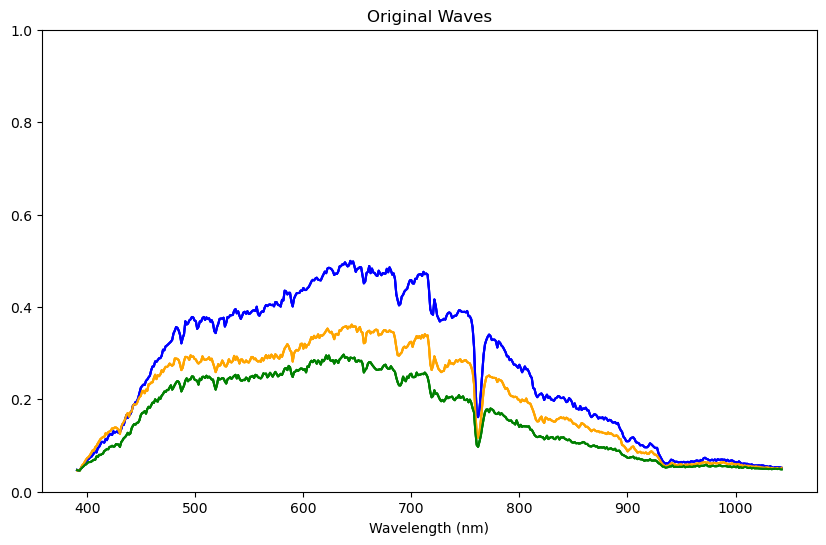

In [39]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']

for x in true_waves:
  for i, wave in enumerate(true_waves):
      wave = wave.squeeze()
      plt.plot(list(wavelengths), wave, color=colors[i % len(colors)])

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Original Waves");

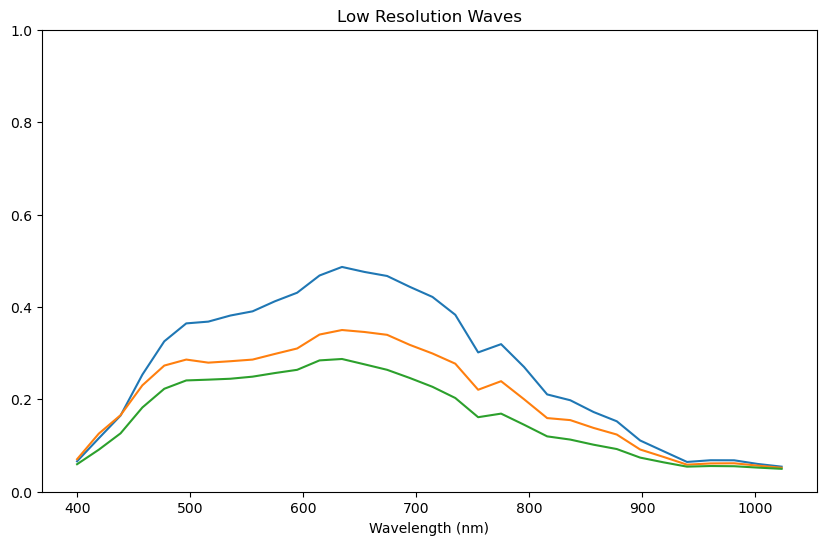

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Original wavelengths array
wavelengths = np.array(wavelengths)  # shape (519,)

# Compute binned wavelengths
bin_size = 16
num_bins = 32
binned_wavelengths = [
    wavelengths[i*bin_size : (i+1)*bin_size].mean() 
    for i in range(num_bins)
]
binned_wavelengths = np.array(binned_wavelengths)

# Plot
plt.figure(figsize=(10, 6))

for wave in corrupted_waves:
    for i, p in enumerate(wave):
        p = p.squeeze()
        plt.plot(binned_wavelengths, p.cpu())  # Use binned wavelengths as x-axis

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Low Resolution Waves");

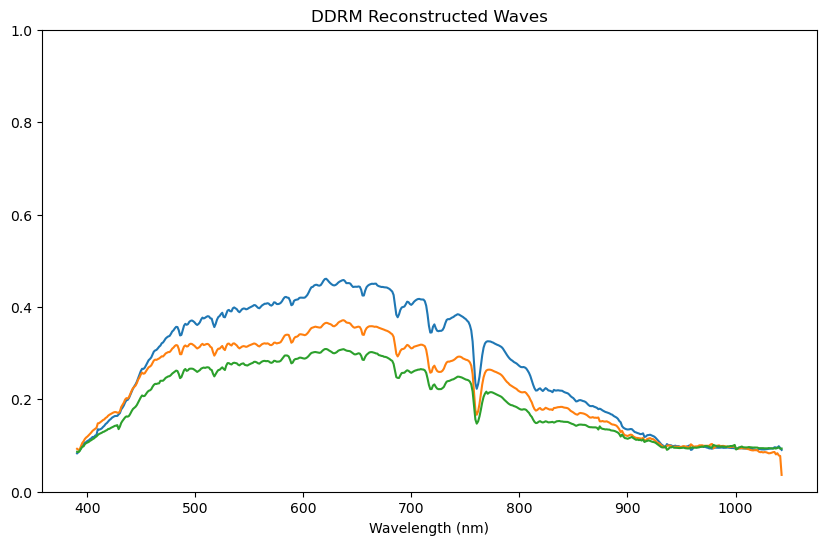

In [41]:
plt.figure(figsize=(10, 6))

for pred in preds:
  for i, p in enumerate(pred[-1]):
      p = p.squeeze()
      plt.plot(wavelengths, p.cpu())

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("DDRM Reconstructed Waves");

# Super Resolution + Denoising

In [42]:
class SuperResWithNoise(H_functions):
    def __init__(self, target_db, high_dim=519, low_dim=32):
        super().__init__()
        self.high_dim = high_dim
        self.low_dim = low_dim
        self.target_db = target_db

        # Compute bin edges for averaging
        bin_edges = torch.linspace(0, high_dim, low_dim + 1).long()  # low_dim+1 edges
        self.bins = [range(bin_edges[i].item(), bin_edges[i + 1].item()) 
                     for i in range(low_dim)]

        # Singular values for DDRM (all ones for now)
        self._singulars = torch.ones(low_dim).cuda()

    def _add_noise(self, y):
        # Gaussian noise based on target dB
        signal_power = torch.mean(y ** 2)
        noise_power = signal_power / (10 ** (self.target_db / 10))
        noise = torch.randn_like(y) * torch.sqrt(noise_power)
        return y + noise

    # Forward: high_dim → low_dim + noise
    def H(self, x):
        B, C, L = x.shape
        assert L == self.high_dim
        y = torch.zeros(B, C, self.low_dim, device=x.device)
        for idx, bin_range in enumerate(self.bins):
            y[:, :, idx] = x[:, :, bin_range].mean(dim=2)
        return self._add_noise(y)

    # Adjoint: low_dim → high_dim (repeat values)
    def Ht(self, y):
        B, C, L = y.shape
        assert L == self.low_dim
        x = torch.zeros(B, C, self.high_dim, device=y.device)
        for idx, bin_range in enumerate(self.bins):
            x[:, :, bin_range] = y[:, :, idx].unsqueeze(2)
        return x

    # Identity U, Ut
    def U(self, vec): return vec
    def Ut(self, vec): return vec

    # DDRM projection operators
    def V(self, vec):  # measurement -> model
        return self.Ht(vec)
    def Vt(self, vec): # model -> measurement
        return self.H(vec)


    def singulars(self):
        return self._singulars

In [47]:
seq = list(range(0, 1500, 50))
H_funcs = SuperResWithNoise(target_db=30)
true_waves = []
corrupted_waves = []
preds = []

for i in range(3):
  rand = random.randint(0 ,50000)
  x = icvl_data[rand].reshape(1, -1, 519)
  predictions = ddrm_inference('/home/nnara/notebooks/ddpm_checkpoint_519band_old.pth', x, seq, H_funcs, 0.02, 0.9, 0.3, 0.5)
  true_waves.append(x)
  preds.append(predictions[0])
  corrupted_waves.append(predictions[2])

/tmp/ipykernel_4085011/2126276042.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
30it [00:00, 128.67it/s]
30it [00:00, 128.62i

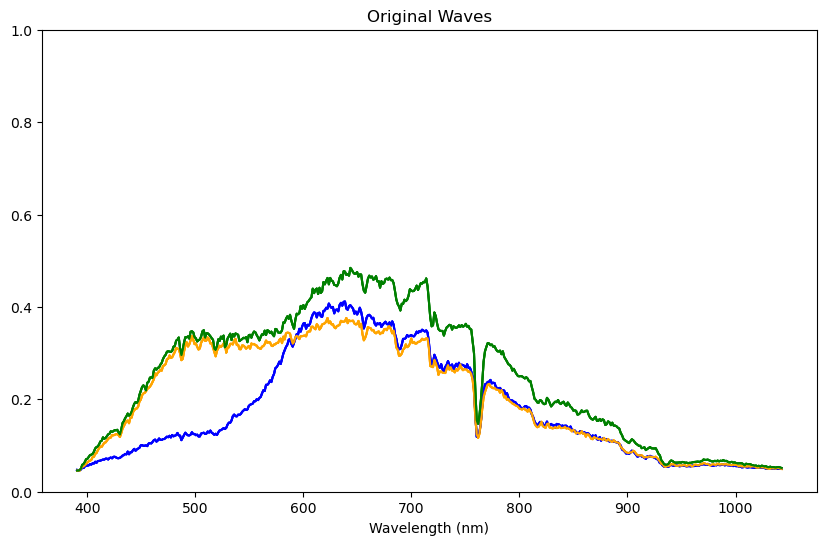

In [48]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']

for x in true_waves:
  for i, wave in enumerate(true_waves):
      wave = wave.squeeze()
      plt.plot(list(wavelengths), wave, color=colors[i % len(colors)])

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Original Waves");

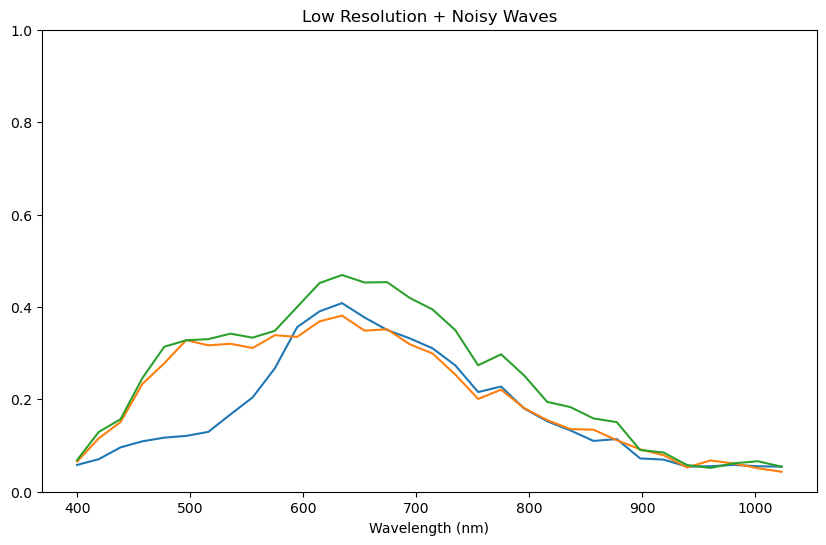

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Original wavelengths array
wavelengths = np.array(wavelengths)  # shape (519,)

# Compute binned wavelengths
bin_size = 16
num_bins = 32
binned_wavelengths = [
    wavelengths[i*bin_size : (i+1)*bin_size].mean() 
    for i in range(num_bins)
]
binned_wavelengths = np.array(binned_wavelengths)

# Plot
plt.figure(figsize=(10, 6))

for wave in corrupted_waves:
    for i, p in enumerate(wave):
        p = p.squeeze()
        plt.plot(binned_wavelengths, p.cpu())  # Use binned wavelengths as x-axis

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Low Resolution + Noisy Waves");

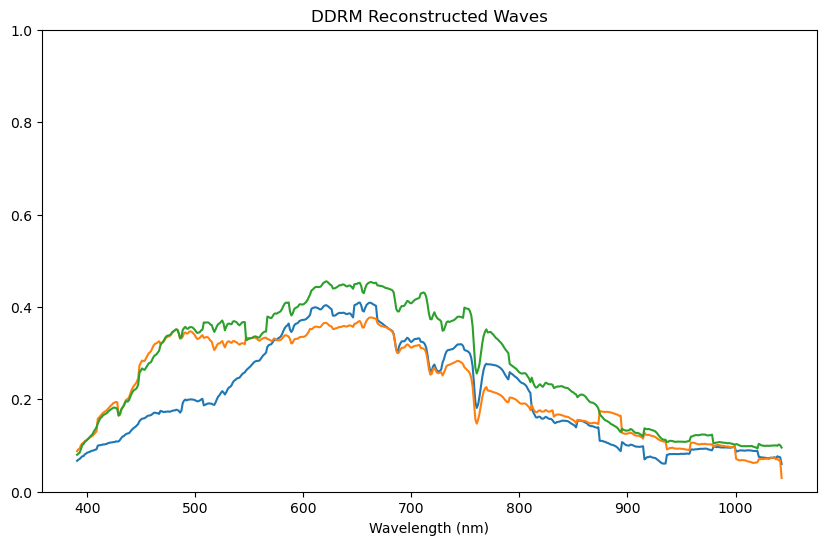

In [50]:
plt.figure(figsize=(10, 6))

for pred in preds:
  for i, p in enumerate(pred[-1]):
      p = p.squeeze()
      plt.plot(wavelengths, p.cpu())

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("DDRM Reconstructed Waves");